<br><font size="6px"><b><center> Stellar Structure Equations </center></b></font>

In [1]:
%load_ext autoreload
%autoreload 1
%matplotlib notebook
%pylab

import io
import subprocess
import pickle

import scipy as sp
import scipy.optimize
import scipy.stats

from IPython.display import Image
from astropy import units as un, constants as ct

%aimport stellar
from stellar import *

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


We make use of ZAMS Model Builder program, written in Fortran, to compute and estimate stellar structures (P, T, R and L) from M and simple composition (X, Y).

# First population with solar metallicity

In this section we carry out a first exploration of the initial parameters of ZAMS program, roughly estimated with the approximated stellar structure equations.

Because ZAMS is more sensible at high stellar masses, we develop an iterative feedback method which uses previous results as input for the initial guesses, inerpolating and extrapolating linearly over all masses. This can be done with few masses until all configurations are found, and then interpolate the data for the desired amount of masses within the same range.

## Initial guess

We estimate the initial guess parameters from the approximate forms of stellar structure equations from Lecture II (Ex. 1). These are written in function of mass, but we need to guess, again, a function which describes the transition between PP and CNO mechanisms of energy production for the $\mathbf{n}$ exponent.

From Burbidge ("Synthesis of the Elements in Stars", p572):

> [...] the CN cycle rate will exceed that for the pp chain only in stars with central temperatures over $18\times 10^6$ degrees.

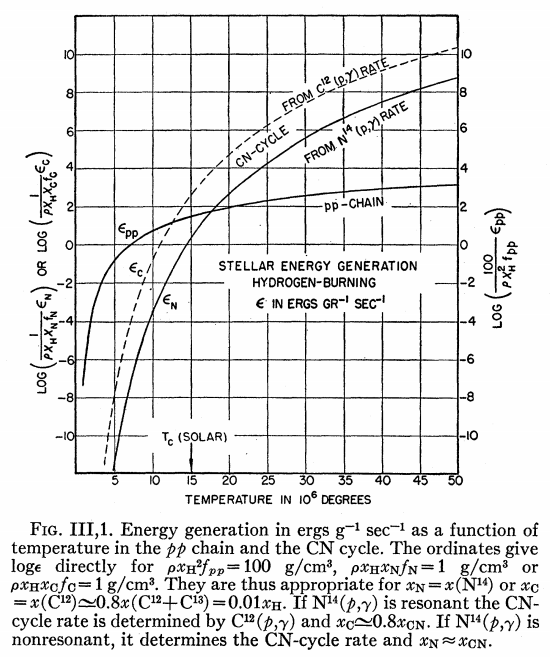

In [8]:
Image("pp-cno.png")

We will assume a linear transition for the energy production exponent $\mathbf{n}$ within $T_6 \in [15, 20]$, with these temperatures translated to mass with a recursive approximation, assuming a mean value for "n".

In [6]:
masses = logspace(log10(0.08), log10(150), 20)
fun_n = def_n(m0=1.2, m1=2, n_pp=4, n_cno=20)
configs = model_configs(masses, 0.747, 0.24, fun_n(masses))

In [7]:
fig, ax = subplots(nrows=2, ncols=2)

# Guesses from TABLE C.1 for comparison
mm = array([1, 3, 15])
pp = array([1.482e17, 1.141e17, 2.769e16])
tt = array([1.442e7, 2.347e7, 3.275e7])
rr = array([6.932e10, 1.276e11, 3.289e11])
ll = array([0.9083, 89.35, 1.96e4])

# Real data from Carrol, Appendix G
c_l, c_r, c_m = loadtxt("stellar_data.txt", skiprows=4, unpack=True)
c_r *= ct.R_sun.cgs.value

# Pressure
i, j = 0, 0
ax[i,j].plot(masses, 10**configs[3])
ax[i,j].scatter(mm, pp, c='red')

ax[i,j].set_xscale('log')
ax[i,j].set_yscale('log')
ax[i,j].set_xlabel('M [$M_\odot$]')
ax[i,j].set_ylabel('$P_C$ [Ba]')

# Temperature
i, j = 0, 1
ax[i,j].plot(masses, 10**configs[4])
ax[i,j].scatter(mm, tt, c='red')

ax[i,j].set_xscale('log')
ax[i,j].set_yscale('log')
ax[i,j].set_xlabel('M [$M_\odot$]')
ax[i,j].set_ylabel('$T_C$ [K]')

# Radius
i, j = 1, 0
ax[i,j].plot(masses, 10**configs[5])
ax[i,j].scatter(mm, rr, c='red', zorder=2)
ax[i,j].scatter(c_m, c_r, c='black')

ax[i,j].set_xscale('log')
ax[i,j].set_yscale('log')
ax[i,j].set_xlabel('M [$M_\odot$]')
ax[i,j].set_ylabel('$R$ [cm]')

# Luminosity
i, j = 1, 1
ax[i,j].plot(masses, 10**configs[6]/L_SUN)
ax[i,j].scatter(mm, ll, c='red', zorder=2)
ax[i,j].scatter(c_m, c_l, c='black')

ax[i,j].set_xscale('log')
ax[i,j].set_yscale('log')
ax[i,j].set_xlabel('M [$M_\odot$]')
ax[i,j].set_ylabel('$L$ [$L_\odot$]')


fig.tight_layout()

<IPython.core.display.Javascript object>

The data only show one tendency, corresponding to the fitted $n=8.84$. We expected two tencencies, one with $n=4$ (pp) and other within $n=[4, 20]$ (n=20 CNO)

## Development of the recursive stellar population function

**FIRST STELLAR POPULATION**

We build the star population with the previous configuration:

In [3]:
stars, i_succ = stellar._build_stellar_population(configs)

In [4]:
_file = "data/first_stars_solar_met.pkl"

# with open(_file, "wb") as f:
#     pickle.dump((stars, configs, i_succ), f)

with open(_file, "rb") as f:
    stars, configs, i_succ = pickle.load(f)

masses = configs[0]

<IPython.core.display.Javascript object>


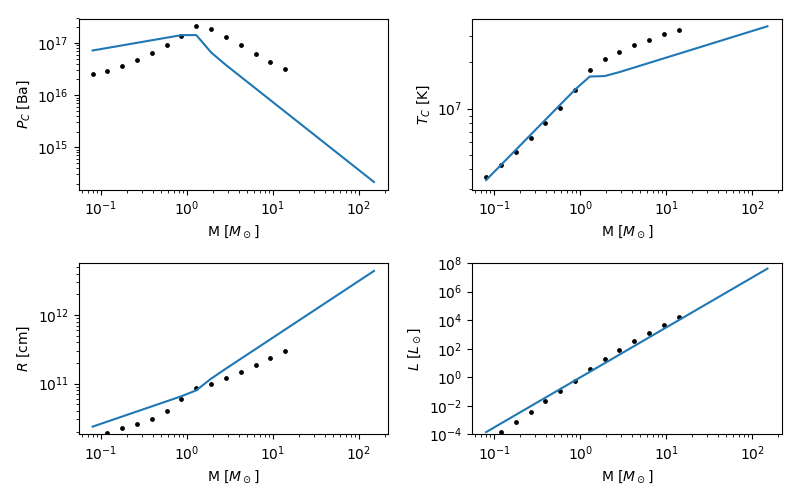

In [5]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 5))

plot_population_profiles(ax, configs, stars)

ax[1,1].set_ylim([1e-4, 1e8])

fig.tight_layout()

The Mass-Luminosity relation behaves as expected, but the core temperature Tc deviates at M >~ 0.9 M_sun. Discrepancy in Pc and R may be solved adjusting the 'n' exponent function.

**RECURSIVE REBUILD USING THE RESULTS AS INITIAL GUESSES**

For each guess we interpolate/extrapolate linearly the previous results. This way, 'zams' reaches each of the interpolated solution faster, and we can explore an even more wide range of masses. This method can be applied recursively to find out its actual limits.

In [16]:
# LOAD THE OLD DATA FROM ABOVE BEFORE EXECUTING THIS CELL

old_configs = configs.copy()
old_stars = stars.copy()
old_i_succ = i_succ.copy()
old_masses = masses.copy()

masses = logspace(log10(0.08), log10(150), 100)

In [17]:
# INITIAL GUESSES FROM PREVIOUS SOLUTIONS, now with more points
configs = interp_configs(
    masses,
    0.7, 0.29,
    old_configs[0,old_i_succ],
    old_stars[old_i_succ]
)

<IPython.core.display.Javascript object>


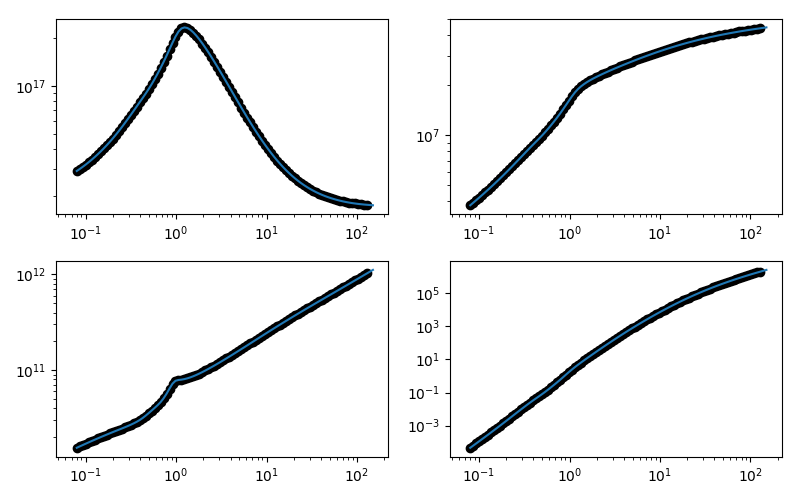

In [18]:
fig, ax = subplots(nrows=2, ncols=2, figsize=(8, 5))

# P
i, j = 0, 0
ax[i,j].scatter(old_masses, 10**old_stars[:,3,0], c='black')
ax[i,j].plot(masses, 10**configs[3])
# T
i, j = 0, 1
ax[i,j].scatter(old_masses, 10**old_stars[:,4,0], c='black')
ax[i,j].plot(masses, 10**configs[4])
# R
i, j = 1, 0
ax[i,j].scatter(old_masses, 10**old_stars[:,2,-1], c='black')
ax[i,j].plot(masses, 10**configs[5])
# L
i, j = 1, 1
ax[i,j].scatter(old_masses, 10**old_stars[:,6,-1]/L_SUN, c='black')
ax[i,j].plot(masses, 10**configs[6]/L_SUN)

for i in range(2):
    for j in range(2):
        ax[i,j].set_xscale('log')
        ax[i,j].set_yscale('log')

fig.tight_layout()

In [19]:
# NEW STELLAR POPULATION
stars, i_succ = stellar._build_stellar_population(configs)

<IPython.core.display.Javascript object>


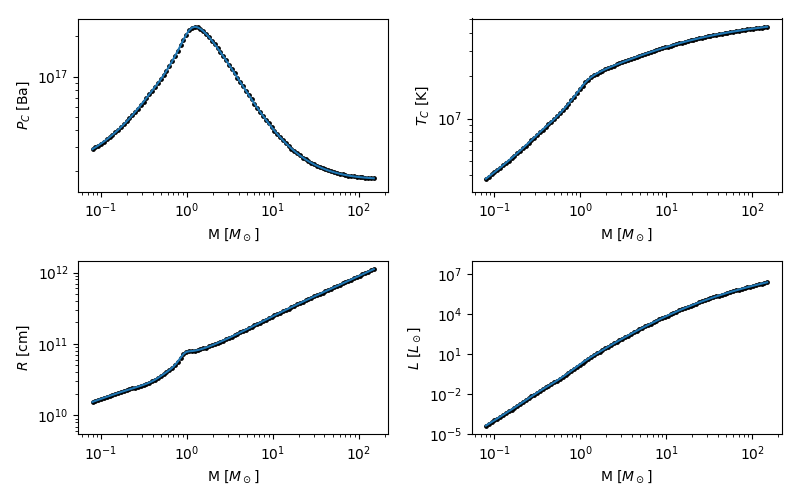

In [20]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 5))

plot_population_profiles(ax, configs, stars)

ax[1,1].set_ylim([1e-5, 1e8])

fig.tight_layout()

## Final stellar population (solar metallicity)

In [77]:
masses = logspace(log10(0.08), log10(150), 20)  # Initial masses
fun_n = def_n(1.2, 2, 4, 20)
configs = model_configs(
    masses,
    0.747,
    0.24,
    fun_n(masses)
)

masses = logspace(log10(0.08), log10(150), 100)  # Final masses
stars, i_succ = build_stellar_population(configs, masses=masses, n_jobs=8)

Computed stars: 100/100 | Success: 100                      
Process finished after 4 iterations.


In [7]:
_file = "data/final_stars_solar_met.pkl"

# with open(_file, "wb") as f:
#     pickle.dump((stars, configs), f)

with open(_file, "rb") as f:
    stars, configs = pickle.load(f)
masses = logspace(log10(0.08), log10(150), 100)  # Final masses

## Hertzsprung–Russell diagram

Using the surface luminosity and estimating the effective temperature as
\begin{equation}
L_i = 4\pi R_i^2 \sigma T_{i,\mathrm{eff}}^4
\end{equation}

In [3]:
lums, rads = 10 ** stars[:, [6,2], -1].T

temps_eff = (lums / (4 * pi * rads**2 * ct.sigma_sb.cgs.value)) ** 0.25

<IPython.core.display.Javascript object>


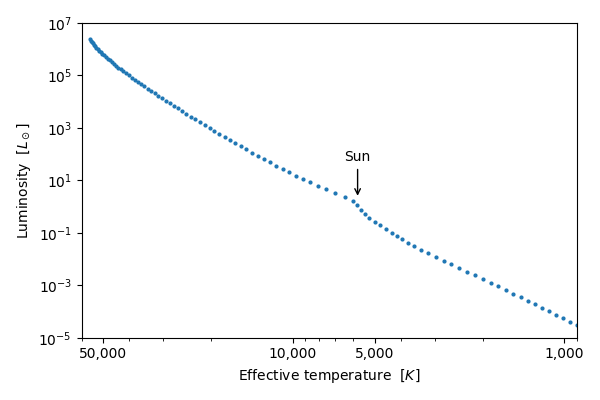

In [6]:
fig, ax = subplots()

ax.scatter(temps_eff, lums/L_SUN, s=4)
# Sun arrow
ax.annotate(
    "Sun",
    xy=(5777, 2),
    xytext=(0, 25),
    ha='center',
    va='bottom',
    textcoords='offset points',
    arrowprops=dict(arrowstyle='->')
)

# x
ax.set_xscale('log')
ax.set_xlim([0.9e3, 6e4])
ax.set_xticks([1e3, 5e3, 1e4, 5e4])
ax.get_xaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)
ax.invert_xaxis()
ax.set_xlabel('Effective temperature  [$K$]')
# y
ax.set_yscale('log')
ax.set_ylim([1e-5, 1e7])
ax.set_ylabel('Luminosity  [$L_\odot$]')

fig.tight_layout()

## Population profiles compared to approx. Stellar Structure eqs.

Comparison with **stellar structure approximated equations**:

<IPython.core.display.Javascript object>


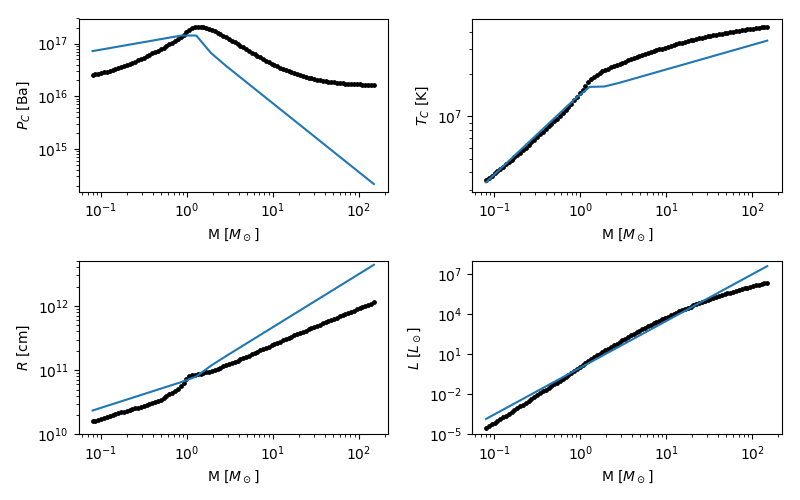

In [81]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 5))

plot_population_profiles(ax, configs, stars, masses)

ax[1,0].set_ylim([1e10, 5e12])
ax[1,1].set_ylim([1e-5, 1e8])

fig.tight_layout()

We find out the 'n' which adjsuts R-M approximated relation to data by means of a linear regression:
\begin{align}
\dfrac{R}{R_\odot} &= \left(\dfrac{M}{M_\odot}\right)^\dfrac{n-1}{n+3} \\[1em]
\log_{10}R &= \dfrac{n-1}{n+3} \log_{10}\dfrac{M}{M_\odot} + \log_{10}R_\odot \\[1em]
\mathrm{ydata} &= A \cdot \mathrm{xdata} + B~,
\quad
n = \dfrac{3A+1}{1-A}
\end{align}

In [3]:
i0 = abs(masses - 1.5).argmin()
xdata = log10(masses[i0:])
ydata = stars[i0:,2,-1]

res = sp.stats.linregress(xdata, ydata)
A = res.slope
B = res.intercept
n = (3*A + 1) / (1 - A)

print("A = {:.4f} ---> n = {:.3f}\n"
      "B = {:.3f} ---> |log10(Rs) - B| = {:.4f}"
      "".format(A, n, B, abs(log10(R_SUN) - B)))

A = 0.5677 ---> n = 6.253
B = 10.826 ---> |log10(Rs) - B| = 0.0167


<IPython.core.display.Javascript object>


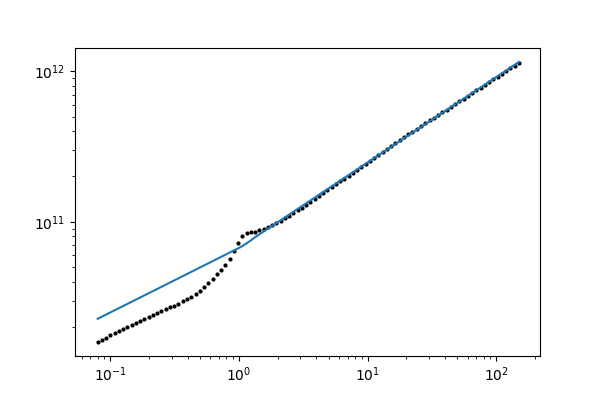

In [83]:
ydata = 10 ** stars[:,2,-1]

fun_n = def_n(0.94, 1.34, 4, n)
y = 10**B * fun_rad(masses, fun_n(masses))


fig, ax = subplots()

ax.scatter(masses, ydata, s=4, c='black')
ax.plot(masses, y)

ax.set_xscale('log')
ax.set_yscale('log')

Same for M-L relation: we observe two slopes, one straight and other curved. We fit the first one

In [84]:
# Straight slope: M < 1.5 Ms
i0 = abs(masses - 1.5).argmin()
xdata = log10(masses[:i0])
ydata = stars[:i0,6,-1]

res = sp.stats.linregress(xdata, ydata)
A = res.slope
B = res.intercept

print("A = {:.4f}\n"
      "B = {:.3f} ---> |log10(Ls) - B| = {:.4f}"
      "".format(A, B, abs(log10(L_SUN) - B)))

A = 4.1958
B = 33.629 ---> |log10(Ls) - B| = 0.0456


<IPython.core.display.Javascript object>


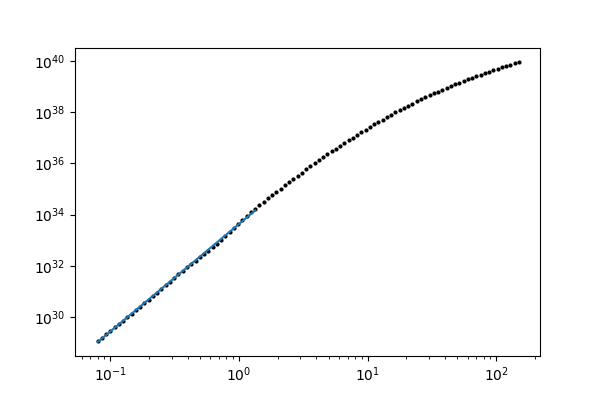

In [85]:
ydata = 10 ** stars[:,6,-1]

x = masses[:i0]
y = 10**B * x**A

fig, ax = subplots()

ax.scatter(masses, ydata, s=4, c='black')
ax.plot(x, y)

ax.set_xscale('log')
ax.set_yscale('log')

## Star structures

Comparison between stars of different masses.

In [56]:
configs_all = interp_configs(
    (0.1, 0.5, 1, 5, 10, 50, 100), # masses to compare
    0.747, 0.24,
    masses,
    starsI
)

stars_all = build_stellar_population(configs_all, load_all=True)

Computed stars:  7/7 | Success:  7
Process finished after 1 iterations.


In [57]:
# PLOT CALCULATIONS
mr = 1 - stars_all[0,1]  # mass fraction

# Intersection points of T plots with T_CNO limit
t_cno = 1.75e7
mr_cno = mr[abs(stars_all[3:,4] - log10(t_cno)).argmin(1)]

<IPython.core.display.Javascript object>


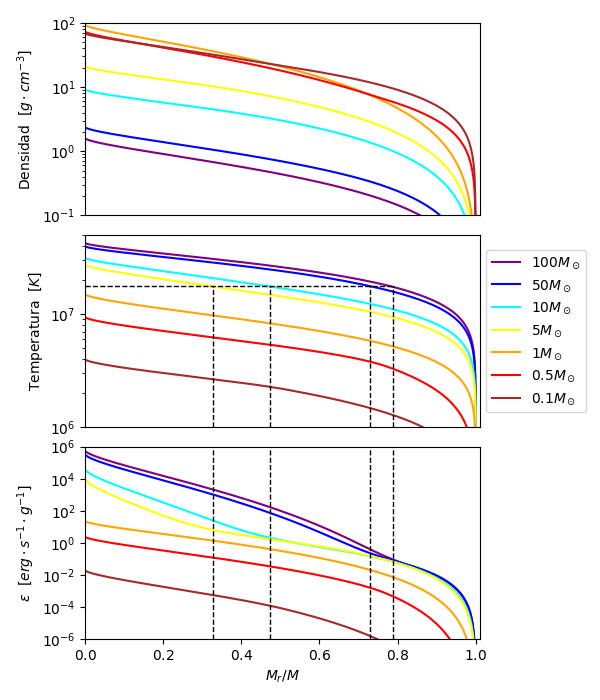

In [58]:
fig, ax = subplots(nrows=3, figsize=(6, 7))

labels = (r"$0.1 M_\odot$", r"$0.5 M_\odot$", r"$1 M_\odot$",
          r"$5 M_\odot$", r"$10 M_\odot$", r"$50 M_\odot$",
          r"$100 M_\odot$")
cs = ('brown', 'red', 'orange', 'yellow', 'cyan', 'blue', 'purple')

# ----- Plots -----
for i in range(len(stars_all)-1, -1, -1):
    ax[0].plot(mr, 10**stars_all[i,5], c=cs[i], label=labels[i])
    ax[1].plot(mr, 10**stars_all[i,4], c=cs[i], label=labels[i])
    ax[2].plot(mr, 10**stars_all[i,7], c=cs[i], label=labels[i])
ax[1].plot([0, mr_cno[-1]], [t_cno]*2, c='black', lw=1, ls='--')
for i in range(4): # PP-CNO separation lines
    ax[1].plot([mr_cno[i]]*2, [1e6, t_cno], c='black', lw=1, ls='--')
    ax[2].axvline(x=mr_cno[i], c='black', lw=1, ls='--')

# ----- Configs -----
for i in range(3):
    ax[i].set_yscale('log')
    ax[i].set_xlim([0, 1.01])

for i in range(2):
    ax[i].xaxis.set_visible(False)

ax[0].set_ylim([1e-1, 1e2])
ax[1].set_ylim([1e6, 5e7])
ax[2].set_ylim([1e-6, 1e6])

ax[-1].set_xlabel(r"$M_r/M$")
ax[0].set_ylabel(r"Densidad  [$g\cdot cm^{-3}$]")
ax[1].set_ylabel(r"Temperatura  [$K$]")
ax[2].set_ylabel(r"$\epsilon$  [$erg\cdot s^{-1}\cdot g^{-1}$]")

fig.tight_layout()
fig.subplots_adjust(hspace=0.1)

for i in range(3):
    box = ax[i].get_position()
    ax[i].set_position([box.x0, box.y0, box.width*0.80, box.height])
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5));

# fig.savefig('Memòria/img/estructura_popI_rho-T-E.pdf')

Comment here the change of dominant reaction process using the change in the slope of the energy generation rate profile.

For the last plot, we realize that intermediate mass [1, 10]Ms have a convective layer at the outermost part of the star where the density is not enough to transfer the energy outwards via radiation. In order to show this layers, we plot again the Lr, this time in function of radius fraction.

<IPython.core.display.Javascript object>


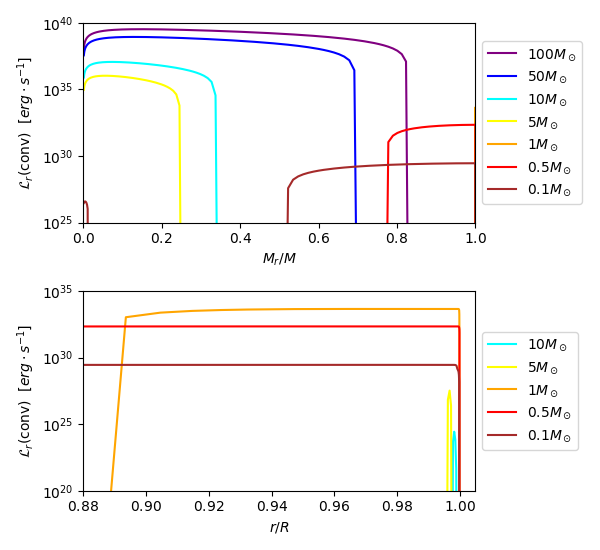

In [44]:
fig, ax = subplots(nrows=2, figsize=(6, 5.5))

for i in range(len(stars_all)-1, -1, -1):
    rr = 10**stars_all[i, 2] / 10**stars_all[i,2,-1]
    ax[0].plot(mr, 10**stars_all[i,9], c=cs[i], label=labels[i])
    
    if i < 5:
        ax[1].plot(rr, 10**stars_all[i, 9], c=cs[i], label=labels[i])

ax[0].set_xlabel(r"$M_r/M$")
ax[1].set_xlabel(r"$r/R$")
for k in range(2):    
    ax[k].set_yscale('log')
    ax[k].set_ylabel(r"$\mathcal{L}_r(\mathrm{conv})$  [$erg\cdot s^{-1}$]")

ax[0].set_xlim([0, 1])
ax[0].set_ylim([1e25, 1e40])
ax[0].set_yticks([1e25, 1e30, 1e35, 1e40])
ax[1].set_xlim([0.88, 1.005])
ax[1].set_ylim([1e20, 1e35])
ax[1].set_yticks(logspace(20, 35, 4))

fig.tight_layout()

for i in range(2):
    box = ax[i].get_position()
    ax[i].set_position([box.x0, box.y0, box.width*0.80, box.height])
    ax[i].legend(loc='center left', bbox_to_anchor=(1, 0.5));
    
# fig.savefig("Memòria/img/estructura_PopI_Lc.pdf")

# Populations with different metallicities

We generate samples from the II and III stellar population and compare them to the I stellar population generated previously with solar metallicity.

| | X | Y | Z |
| --- | :---: | :---: | :---: |
| P III | 0.9005 | 0.0995 | 0 |
| P II | 0.9 | 0.0995 | 0.0005 |
| P I | 0.747 | 0.24 | 0.013 |

In [59]:
#### GLOBAL CHECKPOINT: load all populations ####

with open("data/final_stars_solar_met.pkl", "rb") as f:
    starsI, configs = pickle.load(f)
with open("data/final_stars_popII_popIII.pkl", "rb") as f:
    starsII, starsIII = pickle.load(f)
    
masses = logspace(log10(0.08), log10(150), 100)  # Final masses
stars = array((starsI, starsII, starsIII))
mets = array((
    (0.747,  0.24,   0.013 ), # Pop I
    (0.9,    0.0995, 0.0005), # Pop II
    (0.9005, 0.0995, 0     )  # Pop III
))

## Generation of different stellar populations

We start with PopI results as initial gueses and try to reach PopII and PopIII gradually changing metallicities.

**POPULATION II**

In [56]:
# Rebuilt with starsII
configsII = interp_configs(
    logspace(log10(0.08), log10(150), 20),
    0.9,
    0.0995,
    masses,
    starsI
)

In [42]:
starsII = build_stellar_population(configsII, masses=masses, n_jobs=8)

Computed stars: 100/100 | Success: 98                       
Process finished after 2 iterations.


<IPython.core.display.Javascript object>


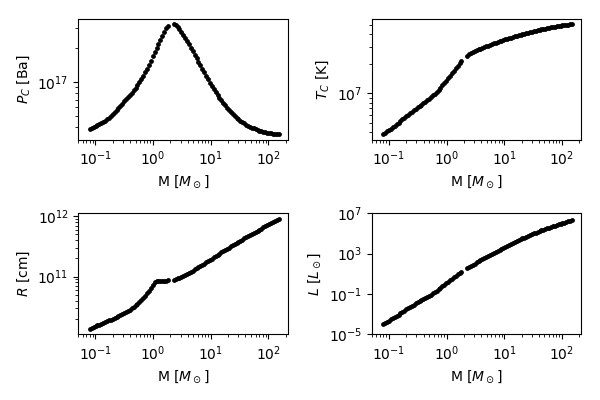

In [58]:
fig, ax = subplots(2, 2)

plot_population_profiles(ax, masses, starsII)

ax[1,1].set_ylim([1e-5, 1e7])

fig.tight_layout()

**POPULATION III**

In [89]:
# Rebuilt with starsIII
configsIII = interp_configs(
    logspace(log10(0.08), log10(150), 20),
    0.9005,
    0.0995,
    masses,
    starsIII
)

In [90]:
starsIII = build_stellar_population(configsIII, masses=masses, n_jobs=8)

Computed stars: 100/100 | Success: 96                       
Process finished after 2 iterations.


<IPython.core.display.Javascript object>


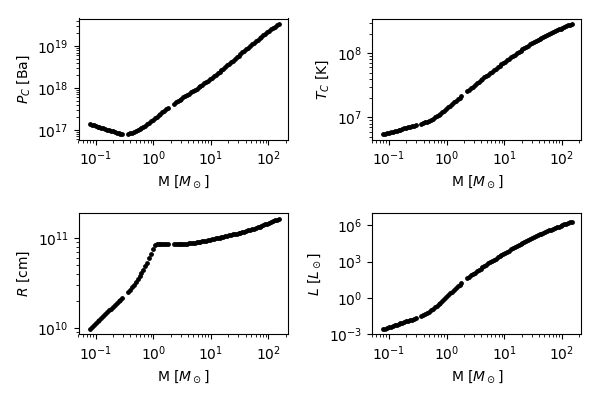

In [91]:
fig, ax = subplots(2, 2)

plot_population_profiles(ax, masses, starsIII)

ax[1,1].set_ylim([1e-3, 1e7])

fig.tight_layout()

In [94]:
_file = "data/final_stars_popII_popIII.pkl"

# with open(_file, "wb") as f:
#     pickle.dump((starsII, starsIII), f)

with open(_file, "rb") as f:
    starsII, starsIII = pickle.load(f)
masses = logspace(log10(0.08), log10(150), 100)  # Final masses

## HRD comparison

In [3]:
lums = 10 ** stars[..., 6, -1]
rads = 10 ** stars[..., 2, -1]

temps_eff = (lums / (4 * pi * rads**2 * ct.sigma_sb.cgs.value)) ** 0.25

<IPython.core.display.Javascript object>


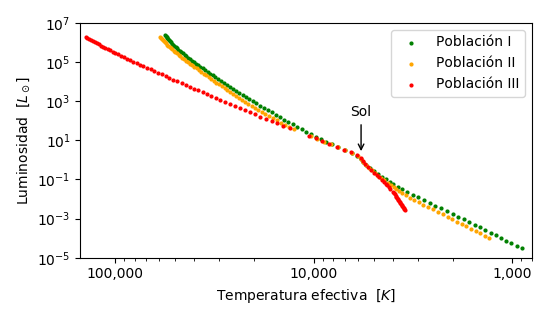

In [19]:
fig, ax = subplots(figsize=(5.5,3.2))

c = ('Green', 'Orange', 'Red')
labels = (
    "Población I",
    "Población II",
    "Población III"
)
for i in range(3):
    ax.scatter(temps_eff[i], lums[i]/L_SUN, s=4, c=c[i], label=labels[i])
# Sun arrow
ax.annotate(
    "Sol",
    xy=(5777, 2),
    xytext=(0, 25),
    ha='center',
    va='bottom',
    textcoords='offset points',
    arrowprops=dict(arrowstyle='->')
)
ax.legend()

# x
ax.set_xscale('log')
ax.set_xlim([800, 1.5e5])
# ax.set_xticks([1e3, 5e3, 1e4, 5e4, 1e5])
ax.get_xaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)
ax.invert_xaxis()
ax.set_xlabel('Temperatura efectiva  [$K$]')
# y
ax.set_yscale('log')
ax.set_ylim([1e-5, 1e7])
ax.set_ylabel('Luminosidad  [$L_\odot$]')

fig.tight_layout()
# fig.savefig("Memòria/img/HRD.pdf")

## Population profiles

<IPython.core.display.Javascript object>


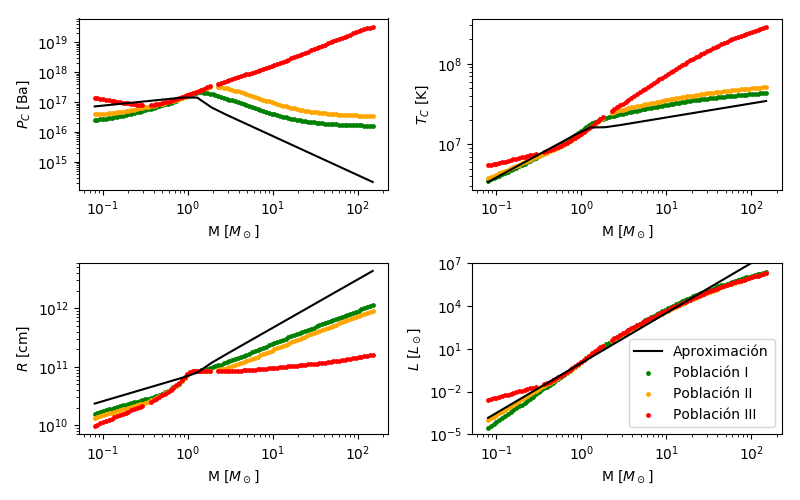

In [22]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 5))

for i in range(2):
    plot_population_profiles(ax, masses, stars[i], 
                             c=c[i], label=labels[i])
aux = plot_population_profiles(ax, masses, stars[2], configs,
                               c=c[2], label=labels[2])
for i in range(4):
    aux[1][i].set_color('Black')
    aux[1][i].set_linewidth(1.5)
    aux[1][i].set_label("Aproximación")
ax[1,1].legend()

ax[1,1].set_ylim([1e-5, 1e7])

fig.tight_layout()
fig.savefig("Memòria/img/perfiles_estelares.pdf")

Comment good prediction at M-L, but fails when nuclear energy production is involved --> We need a better model or at least to adjust the exponential term.

## Star structure comparison

In [60]:
stars_all = empty((3, 3, 14, 199))
for i in range(3):
    print("POPULATION %s" % ('I'*(i+1)))
    configs_all = interp_configs(
        (1, 10, 100), # masses to compare
        *mets[i,:2],
        masses,
        stars[i]
    )
    stars_all[i] = build_stellar_population(configs_all, load_all=True)

POPULATION I
Computed stars:  3/3 | Success:  3
Process finished after 1 iterations.
POPULATION II
Computed stars:  3/3 | Success:  3
Process finished after 1 iterations.
POPULATION III
Computed stars:  3/3 | Success:  3
Process finished after 1 iterations.


In [61]:
# ---- PLOT CALCULATIONS ----
mr = 1 - stars_all[0,0,1]  # mass fractions, same for all

# Intersection points of T plots with T_CNO limit
t_cno = 1.75e7
mr_cno = mr[abs(stars_all[:,1:,4] - log10(t_cno)).argmin(2)]

<IPython.core.display.Javascript object>


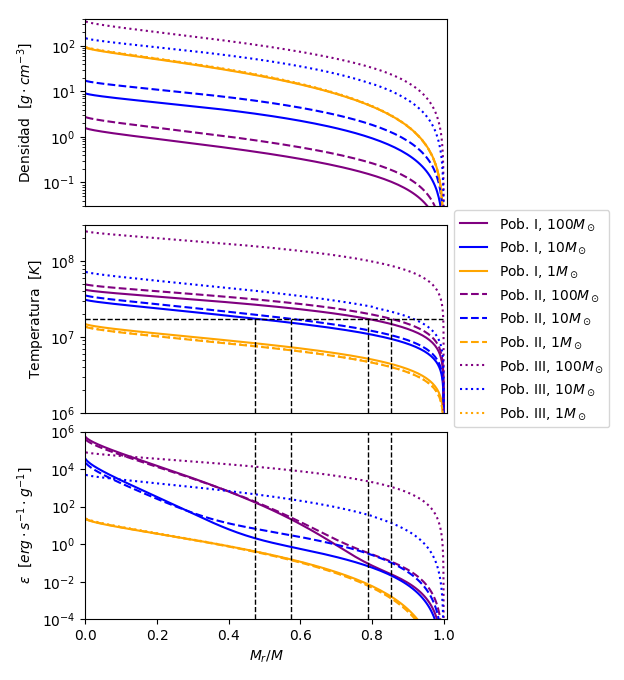

In [63]:
fig, ax = subplots(nrows=3, figsize=(6.24, 6.8))

pop = ("Pob. I, ", "Pob. II, ", "Pob. III, ")
labels = (r"$1 M_\odot$", r"$10 M_\odot$", r"$100 M_\odot$")
cs = ('orange', 'blue', 'purple')
ls = ('-', '--', ':')

# ----- Plots -----
for k in range(3): # population
    for i in range(stars_all.shape[1]-1, -1, -1):
        ax[0].plot(mr, 10**stars_all[k,i,5],
                   c=cs[i], label=pop[k]+labels[i], ls=ls[k])
        ax[1].plot(mr, 10**stars_all[k,i,4],
                   c=cs[i], label=pop[k]+labels[i], ls=ls[k])
        ax[2].plot(mr, 10**stars_all[k,i,7],
                   c=cs[i], label=pop[k]+labels[i], ls=ls[k])
#         ax[3].plot(mr, 10**stars_all[k,i,9],
#                    c=cs[i], label=pop[k]+labels[i], ls=ls[k])
ax[1].plot([0, mr_cno[2,-1]], [t_cno]*2, c='black', lw=1, ls='--')
for k in range(2): # Excluding pop. III (no CNO cycle)
    for i in range(2): # PP-CNO separation lines
        ax[1].plot([mr_cno[k,i]]*2, [1e6, t_cno],
                   c='black', lw=1, ls='--')
        ax[2].axvline(x=mr_cno[k,i], c='black', lw=1, ls='--')

# ----- Configs -----
for i in range(3):
    ax[i].set_yscale('log')
    ax[i].set_xlim([0, 1.01])

for i in range(2):
    ax[i].xaxis.set_visible(False)

# ax[3].set_yticks([1e25, 1e30, 1e35, 1e40])

ax[0].set_ylim([3e-2, 4e2])
ax[1].set_ylim([1e6, 3e8])
ax[2].set_ylim([1e-4, 1e6])
# ax[3].set_ylim([1e32, 1e40])

ax[-1].set_xlabel(r"$M_r/M$")
ax[0].set_ylabel(r"Densidad  [$g\cdot cm^{-3}$]")
ax[1].set_ylabel(r"Temperatura  [$K$]")
ax[2].set_ylabel(r"$\epsilon$  [$erg\cdot s^{-1}\cdot g^{-1}$]")
# ax[3].set_ylabel(r"$\mathcal{L}_r(\mathrm{conv})$  [$erg\cdot s^{-1}$]")

fig.tight_layout()
fig.subplots_adjust(hspace=0.1)

for i in range(3):
    box = ax[i].get_position()
    ax[i].set_position([box.x0, box.y0, box.width*0.7, box.height])
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5));

fig.savefig('Memòria/img/estructura_all-pops_rho-T-E.pdf')

<IPython.core.display.Javascript object>


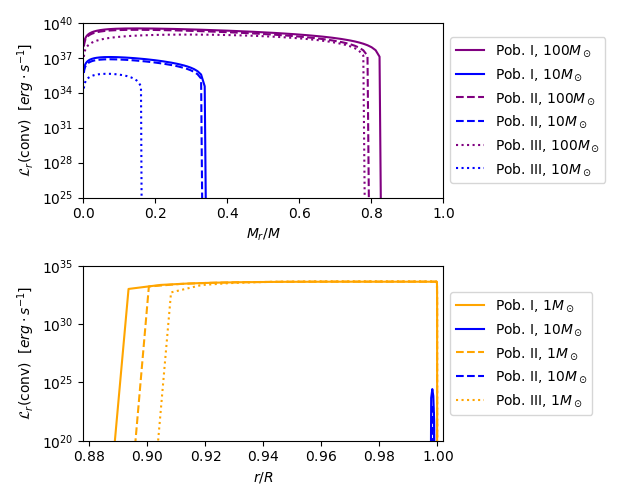

In [72]:
fig, ax = subplots(nrows=2, figsize=(6.24, 5))

for ip in range(3): # population
    for i in range(stars_all.shape[1]-1, 0, -1):
        ax[0].plot(mr, 10**stars_all[ip,i,9],
                   c=cs[i], label=pop[ip]+labels[i], ls=ls[ip])
for ip in range(3):
    for i in range(2): # Excluding 100Ms (no ext. conv. layer)
        if (ip, i) == (2, 1): continue
            
        rr = 10**stars_all[ip,i,2] / 10**stars_all[ip,i,2,-1]
        ax[1].plot(rr, 10**stars_all[ip,i,9],
                   c=cs[i], label=pop[ip]+labels[i], ls=ls[ip])

for i in range(2):
    ax[i].set_yscale('log')
    ax[i].set_ylabel(r"$\mathcal{L}_r(\mathrm{conv})$  [$erg\cdot s^{-1}$]")

ax[0].set_xlim([0, 1])
ax[0].set_ylim([1e25, 1e40])
ax[0].set_xlabel(r"$M_r/M$")

ax[1].set_xlim([0.878, 1.002])
ax[1].set_ylim([1e20, 1e35])
ax[1].set_yticks(10**arange(20, 40, 5.))
ax[1].set_xlabel(r"$r/R$")

fig.tight_layout()
for i in range(2):
    box = ax[i].get_position()
    ax[i].set_position([box.x0, box.y0, box.width*0.7, box.height])
    ax[i].legend(loc='center left', bbox_to_anchor=(1, 0.5));

fig.savefig('Memòria/img/estructura_all-pops_Lc.pdf')